In [3]:
%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

UsageError: Cell magic `%%appyter` not found.


# RNA-seq analysis pipeline with enrichment analysis from Enrichr 
---

By default, we use TCGA data. Users can optionally also upload their own datasets. See the example files in `/example_data` for the proper format.

In [4]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from umap import UMAP
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from maayanlab_bioinformatics.dge import characteristic_direction
from maayanlab_bioinformatics.normalization import log2_normalize, filter_by_var, zscore_normalize
from maayanlab_bioinformatics.utils import merge
import plotly.express as px
import math
from collections import OrderedDict
import json
from jupyter_d3 import scatter_plot
from IPython.display import display, HTML

In [63]:
%%appyter hide_code

{% do SectionField(
    name="DATASET",
    title="Dataset selection",
    subtitle='If using TCGA data, leave both file upload fields blank and simply select the desired cancer type.',
    img = "tcga-logo.png"
) %}


{% do SectionField(
    name='CONFIG',
    title='Analysis parameters',
    img = "cluster-icon.svg"

) %}

{% do SectionField(
    name="ENRICHR_LIBS",
    title="Libraries to include in the Enrichr search",
    img = "enrichr-logo.png"


) %}

{% do SectionField(
    name="L1000FWD",
    title="L1000FWD search parameters",
    img = "l1000fwd.png"
) %}



UsageError: Cell magic `%%appyter` not found.


In [64]:
%%appyter code_eval

data_filename = "{{ FileField(name='data_filename', label='RNA-seq data file (.csv)', description='Upload RNA-seq dataset in csv format. The index of the dataset are genes, the columns are samples.', section='DATASET').value }}"

clinical_data_filename = "{{ FileField(name='clinical_data_filename', label='Clinical data file (.csv)', description='Upload clinical data in csv format. The first column should contain patient IDs corresponding to those in the RNA-seq file. Each subsequent column is a clinical data field.', section='DATASET').value }}"

cancer = '''{{ ChoiceField(
        name = "cancer",
        label = "Cancer type",
        description="The value provided as the primary diagnosis on cases in TCGA.",
        choices=["Infiltrating duct carcinoma, NOS","Squamous cell carcinoma, NOS","Lobular carcinoma, NOS","Acute myeloid leukemia, NOS","Hepatocellular carcinoma, NOS","Serous cystadenocarcinoma, NOS","Endometrioid adenocarcinoma, NOS","Adenocarcinoma, NOS","Clear cell adenocarcinoma, NOS","Glioblastoma","Mucinous adenocarcinoma","Transitional cell carcinoma","Malignant melanoma, NOS","Papillary adenocarcinoma, NOS"],
        section="DATASET",
        default="Serous cystadenocarcinoma, NOS" ) 
}}'''
    
# Dimensionality reduction parameters

n_pca_components = {{IntField(
    name='n_pca_components',
    label='Number of PCA components to use for UMAP',
    description='The number of \'top\' PCA components to use for further dimensionality reduction using the UMAP algorithm',
    default=10,
    min=0,
    max=100,
    section='CONFIG',
)}}

n_neighbors = {{IntField(
    name='n_neighbors',
    label='Number of neighbors for each projected datapoint computed by UMAP',
    description='Smaller values preserve local manifold structure in the dataset as opposed to overall global structure',
    default=2,
    min=2,
    max=20,
    section='CONFIG',
)}}

min_cluster_dist = {{FloatField(
    name='min_cluster_dist',
    label='Minimum distance between UMAP-projected points',
    description='How tightly packed points produced by dimensionality reduction with UMAP are permitted to be.',
    default=0.3,
    min=0.1,
    max=1,
    section='CONFIG',
)}}


# The number of 'top' genes to use for differential expression
top_n_genes = {{IntField(
    name='top_n_genes',
    label='Number of Genes',
    description='The number of \'top\' genes to use for differential expression',
    default=250,
    min=100,
    max=1000,
    section='CONFIG',
)}}

# The number of 'top' results to keep from enrichment analysis
top_n_results = {{ IntField(
    name='top_n_results',
    label='Number of Top Enrichment Results',
    description='The number of \'top\' results to keep from enrichment analysis',
    default=5,
    min=1,
    max=100,
    section='CONFIG',
)}}

transcription_libraries = {{ MultiChoiceField(name='transcription_libraries', 
                                              description='Select the Enrichr libraries you would like in your figure.', 
                                              label='Transcription', 
                                              default=[], 
                                              section = 'ENRICHR_LIBS',
                                              choices=[
                                                    'ARCHS4_TFs_Coexp',
                                                    'ChEA_2016',
                                                    'ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X',
                                                    'ENCODE_Histone_Modifications_2015',
                                                    'ENCODE_TF_ChIP-seq_2015',
                                                    'Epigenomics_Roadmap_HM_ChIP-seq',
                                                    'Enrichr_Submissions_TF-Gene_Coocurrence',
                                                    'Genome_Browser_PWMs',
                                                    'lncHUB_lncRNA_Co-Expression',
                                                    'miRTarBase_2017',
                                                    'TargetScan_microRNA_2017',
                                                    'TF-LOF_Expression_from_GEO',
                                                    'TF_Perturbations_Followed_by_Expression',
                                                    'Transcription_Factor_PPIs',
                                                    'TRANSFAC_and_JASPAR_PWMs',
                                                    'TRRUST_Transcription_Factors_2019'
                                                ]) }}

pathways_libraries = {{ MultiChoiceField(name='pathways_libraries', 
                                         description='Select the Enrichr libraries you would like in your figure.', 
                                         label='Pathways', 
                                         default=[], 
                                         section='ENRICHR_LIBS',
                                         choices=[
                                                    'ARCHS4_Kinases_Coexp',
                                                    'BioCarta_2016',
                                                    'BioPlanet_2019',
                                                    'BioPlex_2017',
                                                    'CORUM',
                                                    'Elsevier_Pathway_Collection',
                                                    'HMS_LINCS_KinomeScan',
                                                    'HumanCyc_2016',
                                                    'huMAP',
                                                    'KEA_2015',
                                                    'KEGG_2019_Human',
                                                    'KEGG_2019_Mouse',
                                                    'Kinase_Perturbations_from_GEO_down',
                                                    'Kinase_Perturbations_from_GEO_up',
                                                    'L1000_Kinase_and_GPCR_Perturbations_down',
                                                    'L1000_Kinase_and_GPCR_Perturbations_up',
                                                    'NCI-Nature_2016',
                                                    'NURSA_Human_Endogenous_Complexome',
                                                    'Panther_2016',
                                                    'Phosphatase_Substrates_from_DEPOD',
                                                    'PPI_Hub_Proteins',
                                                    'Reactome_2016',
                                                    'SILAC_Phosphoproteomics',
                                                    'SubCell_BarCode',
                                                    'Virus-Host_PPI_P-HIPSTer_2020',
                                                    'WikiPathways_2019_Human',
                                                    'WikiPathways_2019_Mouse']) }} 

ontologies_libraries = {{ MultiChoiceField(name='ontologies_libraries', 
                                           description='Select the Enrichr libraries you would like in your figure.', 
                                           label='Ontologies', 
                                           default=[], 
                                           section = 'ENRICHR_LIBS',
                                           choices=[
                                                'GO_Biological_Process_2018',
                                                'GO_Cellular_Component_2018',
                                                'GO_Molecular_Function_2018',
                                                'Human_Phenotype_Ontology',
                                                'Jensen_COMPARTMENTS',
                                                'Jensen_DISEASES',
                                                'Jensen_TISSUES',
                                                'MGI_Mammalian_Phenotype_Level_4_2019'
                                           ]) }}
    
diseases_drugs_libraries = {{ MultiChoiceField(name='diseases_drugs_libraries', 
                                               description='Select the Enrichr libraries you would like in your figure.', 
                                               label='Diseases/Drugs', 
                                               default=[], 
                                               section = 'ENRICHR_LIBS',
                                               choices=[    
                                                    'Achilles_fitness_decrease',
                                                    'Achilles_fitness_increase',
                                                    'ARCHS4_IDG_Coexp',
                                                    'ClinVar_2019',
                                                    'dbGaP',
                                                    'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
                                                    'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
                                                    'DisGeNET',
                                                    'DrugMatrix',
                                                    'DSigDB',
                                                    'GeneSigDB',
                                                    'GWAS_Catalog_2019',
                                                    'LINCS_L1000_Chem_Pert_down',
                                                    'LINCS_L1000_Chem_Pert_up',
                                                    'LINCS_L1000_Ligand_Perturbations_down',
                                                    'LINCS_L1000_Ligand_Perturbations_up',
                                                    'MSigDB_Computational',
                                                    'MSigDB_Oncogenic_Signatures',
                                                    'Old_CMAP_down',
                                                    'Old_CMAP_up',
                                                    'OMIM_Disease',
                                                    'OMIM_Expanded',
                                                    'PheWeb_2019',
                                                    'Rare_Diseases_AutoRIF_ARCHS4_Predictions',
                                                    'Rare_Diseases_AutoRIF_Gene_Lists',
                                                    'Rare_Diseases_GeneRIF_ARCHS4_Predictions',
                                                    'Rare_Diseases_GeneRIF_Gene_Lists',
                                                    'UK_Biobank_GWAS_v1',
                                                    'Virus_Perturbations_from_GEO_down',
                                                    'Virus_Perturbations_from_GEO_up',
                                                    'VirusMINT']) }}
    
cell_types_libraries = {{ MultiChoiceField(name='cell_types_libraries', 
                                           description='Select the Enrichr libraries you would like in your figure.', 
                                           label='Cell Types', 
                                           default=[], 
                                           section = 'ENRICHR_LIBS',
                                           choices=[        
                                                'Allen_Brain_Atlas_down',
                                                'Allen_Brain_Atlas_up',
                                                'ARCHS4_Cell-lines',
                                                'ARCHS4_Tissues',
                                                'Cancer_Cell_Line_Encyclopedia',
                                                'CCLE_Proteomics_2020',
                                                'ESCAPE',
                                                'GTEx_Tissue_Sample_Gene_Expression_Profiles_down',
                                                'GTEx_Tissue_Sample_Gene_Expression_Profiles_up',
                                                'Human_Gene_Atlas',
                                                'Mouse_Gene_Atlas',
                                                'NCI-60_Cancer_Cell_Lines',
                                                'ProteomicsDB_2020',
                                                'Tissue_Protein_Expression_from_Human_Proteome_Map']) }}    
    
    
    
miscellaneous_libraries = {{ MultiChoiceField(name='miscellaneous_libraries', 
                                              description='Select the Enrichr libraries you would like in your figure.', 
                                              label='Miscellaneous', 
                                              default=[], 
                                              section = 'ENRICHR_LIBS',
                                              choices=[            
                                                    'Chromosome_Location_hg19',
                                                    'Data_Acquisition_Method_Most_Popular_Genes',
                                                    'Enrichr_Libraries_Most_Popular_Genes',
                                                    'Genes_Associated_with_NIH_Grants',
                                                    'HMDB_Metabolites',
                                                    'HomoloGene',
                                                    'InterPro_Domains_2019',
                                                    'NIH_Funded_PIs_2017_AutoRIF_ARCHS4_Predictions',
                                                    'NIH_Funded_PIs_2017_GeneRIF_ARCHS4_Predictions',
                                                    'NIH_Funded_PIs_2017_Human_AutoRIF',
                                                    'NIH_Funded_PIs_2017_Human_GeneRIF',
                                                    'Pfam_Domains_2019',
                                                    'Pfam_InterPro_Domains',
                                                    'Table_Mining_of_CRISPR_Studies']) }}    
    
    
legacy_libraries = {{ MultiChoiceField(name='legacy_libraries', 
                                       description='Select the Enrichr libraries you would like in your figure.', 
                                       label='Legacy', 
                                       default=[], 
                                       section = 'ENRICHR_LIBS',
                                       choices=[                
                                            'BioCarta_2013',
                                            'BioCarta_2015',
                                            'ChEA_2013',
                                            'ChEA_2015',
                                            'Chromosome_Location',
                                            'Disease_Signatures_from_GEO_down_2014',
                                            'Disease_Signatures_from_GEO_up_2014',
                                            'Drug_Perturbations_from_GEO_2014',
                                            'ENCODE_Histone_Modifications_2013',
                                            'ENCODE_TF_ChIP-seq_2014',
                                            'GO_Biological_Process_2013',
                                            'GO_Biological_Process_2015',
                                            'GO_Biological_Process_2017',
                                            'GO_Biological_Process_2017b',
                                            'GO_Cellular_Component_2013',
                                            'GO_Cellular_Component_2015',
                                            'GO_Cellular_Component_2017',
                                            'GO_Cellular_Component_2017b',
                                            'GO_Molecular_Function_2013',
                                            'GO_Molecular_Function_2015',
                                            'GO_Molecular_Function_2017',
                                            'GO_Molecular_Function_2017b',
                                            'HumanCyc_2015',
                                            'KEA_2013',
                                            'KEGG_2013',
                                            'KEGG_2015',
                                            'KEGG_2016',
                                            'MGI_Mammalian_Phenotype_2013',
                                            'MGI_Mammalian_Phenotype_2017',
                                            'MGI_Mammalian_Phenotype_Level_3',
                                            'MGI_Mammalian_Phenotype_Level_4',
                                            'NCI-Nature_2015',
                                            'Panther_2015',
                                            'Reactome_2013',
                                            'Reactome_2015',
                                            'TargetScan_microRNA',
                                            'Tissue_Protein_Expression_from_ProteomicsDB',
                                            'WikiPathways_2013',
                                            'WikiPathways_2015',
                                            'WikiPathways_2016']) }} 

crowd_libraries = {{ MultiChoiceField(name='crowd_libraries', 
                                      description='Select the Enrichr libraries you would like in your figure.', 
                                      label='Crowd', 
                                      default=[],
                                      section = 'ENRICHR_LIBS',
                                      choices=[                
                                            'Aging_Perturbations_from_GEO_down',
                                            'Aging_Perturbations_from_GEO_up',
                                            'Disease_Perturbations_from_GEO_down',
                                            'Disease_Perturbations_from_GEO_up',
                                            'Drug_Perturbations_from_GEO_down',
                                            'Drug_Perturbations_from_GEO_up',
                                            'Gene_Perturbations_from_GEO_down',
                                            'Gene_Perturbations_from_GEO_up',
                                            'Ligand_Perturbations_from_GEO_down',
                                            'Ligand_Perturbations_from_GEO_up',
                                            'MCF7_Perturbations_from_GEO_down',
                                            'MCF7_Perturbations_from_GEO_up',
                                            'Microbe_Perturbations_from_GEO_down',
                                            'Microbe_Perturbations_from_GEO_up',
                                            'RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO',
                                            'SysMyo_Muscle_Gene_Sets']) }}


top_n_signatures = {{IntField(
    name='top_n_signatures',
    label='Number of top L1000 signatures',
    description='The number of \'top\' most similar L1000 signatures to load for each cluster',
    default=50,
    min=0,
    max=50,
    section='L1000FWD',
)}}


enrichr_libraries = OrderedDict([
    ('Diseases/Drugs', diseases_drugs_libraries), 
    ('Ontologies', ontologies_libraries),
    ('Cell Type', cell_types_libraries),
    ('Pathways', pathways_libraries),
    ('Transcription', transcription_libraries),
    ('Legacy', legacy_libraries),
    ('Crowd', crowd_libraries)
])

UsageError: Cell magic `%%appyter` not found.


In [65]:
%%appyter hide_code
'''
# values to test the notebook locally

cancer = "Glioblastoma"
# Dimensionality reduction parameters
n_pca_components = 10
n_neighbors = 2
min_cluster_dist = 0.3
# The number of 'top' genes to use for differential expression
top_n_genes = 250
# The number of 'top' results to keep from enrichment analysis
top_n_results = 5
transcription_libraries = []
pathways_libraries = [] 
ontologies_libraries = []
diseases_drugs_libraries = []
cell_types_libraries = []    
miscellaneous_libraries = ['Chromosome_Location_hg19']    
legacy_libraries = ['BioCarta_2013'] 
crowd_libraries = ['Disease_Perturbations_from_GEO_down']
enrichr_libraries = OrderedDict([
    ('Diseases/Drugs', diseases_drugs_libraries), 
    ('Ontologies', ontologies_libraries),
    ('Cell Type', cell_types_libraries),
    ('Pathways', pathways_libraries),
    ('Transcription', transcription_libraries),
    ('Legacy', legacy_libraries),
    ('Crowd', crowd_libraries)
])



data_filename = "./example_data/data.csv"
clinical_data_filename = "./example_data/clinical_data.csv"



'''


UsageError: Cell magic `%%appyter` not found.


## Import dataset

If using user-uploaded data, we access those files and set the necessary index names.

Otherwise, we first download the data containing RNA-seq profiles for the selected cancer type from TCGA and the corresponding clinical data for those cases.

The RNA-seq data that is provided has already been processed using the HTSeq Python package, which calculates the number of mapped reads to each gene.

In [6]:
%%appyter hide_code

# Utility function for saving the dataset
def save_data(cancer_type,
              df_data_norm_km,
              df_data_norm_pca,
              df_data_norm_umap,
              df_diff_expr,
              df_aucs):
    
    # create the root dir
    root_dir = f'./processed_data/{cancer_type}'
    os.makedirs(root_dir, exist_ok=True)

    # /clustering/graphclust/clusters.csv
    #   Barcode,Cluster
    os.makedirs(f'{root_dir}/clustering/graphclust', exist_ok=True)
    df_data_norm_km.to_csv(f'{root_dir}/clustering/graphclust/clusters.csv')
    
    # /pca/10_components/projection.csv
    #   Barcode,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10
    os.makedirs(f'{root_dir}/pca/{n_pca_components}_components', exist_ok=True)
    df_data_norm_pca.to_csv(f'{root_dir}/pca/{n_pca_components}_components/projection.csv')
    
    # /umap/2_components/projection.csv
    #   Barcode,UMAP-1,UMAP-2
    os.makedirs(f'{root_dir}/umap/2_components', exist_ok=True)
    df_data_norm_umap.to_csv(f'{root_dir}/umap/2_components/projection.csv')
    
     # /diffexp/graphclust/differential_expression.csv
    #   Feature Name,Cluster 2 Log2 fold change,Cluster 0 Log2 fold change,Cluster 1 Log2 fold change,Cluster 3 Log2 fold change,Cluster 2 Adjusted p value,Cluster 0 Adjusted p value,Cluster 1 Adjusted p value,Cluster 3 Adjusted p value,Cluster 2 Mean Counts,Cluster 0 Mean Counts,Cluster 1 Mean Counts,Cluster 3 Mean Counts,Feature Name
    os.makedirs(f'{root_dir}/diffexp/graphclust', exist_ok=True)
    df_diff_expr.to_csv(f'{root_dir}/diffexp/graphclust/differential_expression.csv')
    
    # /cluster_aucs.csv
    #   ,2,0,1,3
    df_aucs.to_csv(f'{root_dir}/cluster_aucs.csv')

UsageError: Cell magic `%%appyter` not found.


In [7]:
user_data = False
if (data_filename != "" and clinical_data_filename != ""): user_data = True


In [8]:
data_index = "symbol"
clinical_index = "case_id"

if (user_data):
    df_data = pd.read_csv(data_filename, index_col=0).sort_index()
    df_clinical = pd.read_csv(clinical_data_filename, index_col=0).sort_index()

    df_data.index.name = "symbol"
    df_clinical.index.name = "case_id"
    
    display(df_data.head())
    display(df_clinical.head())
else:
    # Import the RNA-seq and clinical DataFrames with only entries corresponding 
    # the selected cancer type
    aws_url = f'https://tcga-enrichr-viewer.s3.amazonaws.com/{cancer.replace(" ", "%20")}'

    df_data = pd.read_csv(f'{aws_url}_data.csv')
    df_data = df_data.set_index("symbol")

    df_clinical = pd.read_csv(f'{aws_url}_clinical_data.csv')
    df_clinical = df_clinical.set_index("case_id")
    df_clinical = df_clinical.replace("not reported", np.nan)


In [9]:
# Get a list of the clinical features with multiple unique values
features = df_clinical.columns.values

def has_unique_values(feature):
    unique = df_clinical[feature].dropna().unique()
    if len(unique) >= 1: return True
    return False

if (not user_data):
    features = list(filter(
        lambda x: not x in ["primary_diagnosis","submitter_id", "updated_datetime","diagnosis_id", "demographic_id"] 
        and has_unique_values(x), features))

    df_clinical = df_clinical[features]
else:
    features = list(filter(
        lambda x: has_unique_values(x), features))
    df_clinical = df_clinical[features]


    
print(f"{df_clinical.shape[0]} cases, {len(features)} features")

display(df_clinical.head())

168 cases, 21 features


,icd_10_code,age_at_diagnosis,year_of_diagnosis,tissue_or_organ_of_origin,days_to_birth,age_at_index,year_of_death,days_to_death,morphology,prior_malignancy,...,state,ethnicity,days_to_last_follow_up,year_of_birth,synchronous_malignancy,days_to_diagnosis,prior_treatment,vital_status,gender,site_of_resection_or_biopsy
case_id,,,,,,,,,,,,,,,,,,,,,
884f867b-4a8b-4b67-8fe4-ab3f068be84e,C71.9,26395,2010,"Brain, NOS",-26395,72,2010.0,108.0,9440/3,NaN,...,released,not hispanic or latino,108.0,1938,Not Reported,0,No,Dead,female,"Brain, NOS"
2188c194-dfe4-4471-9b8b-050db1a1062c,C71.9,11112,2008,"Brain, NOS",-11112,30,NaN,632.0,9440/3,NaN,...,released,not hispanic or latino,165.0,1978,Not Reported,0,No,Dead,male,"Brain, NOS"
3f960d3b-a58c-43d0-a8a4-f3555b399c9d,C71.9,18832,2010,"Brain, NOS",-18832,51,2010.0,254.0,9440/3,NaN,...,released,not hispanic or latino,254.0,1959,Not Reported,0,No,Dead,male,"Brain, NOS"
e876dd29-68b0-4bf1-83d1-488c40068a35,C71.9,24134,2010,"Brain, NOS",-24134,66,NaN,585.0,9440/3,NaN,...,released,not hispanic or latino,323.0,1944,Not Reported,0,No,Dead,male,"Brain, NOS"
d6de8d1c-e5ff-45cd-b53e-f943d2578713,C71.9,18433,2006,"Brain, NOS",-18433,50,2009.0,1458.0,9440/3,NaN,...,released,NaN,1458.0,1956,Not Reported,0,No,Dead,female,"Brain, NOS"


## Process data and compute clusters

Next, we'll need to normalize the RNA-seq data, reduce its dimensionality using PCA and UMAP, and compute clusters of RNA-seq profiles.

In [10]:
# Data size stats

df_library_size = pd.DataFrame(
    {
        'n_reads': df_data[df_data > 0].count(),
        'log_n_reads': np.log2(df_data[df_data > 0].count() + 1),
        'n_expressed_genes': df_data.sum(),
    }).sort_values('n_reads', ascending=False)

df_library_size.index.name = "case_id"
display(df_library_size.head()) 

,n_reads,log_n_reads,n_expressed_genes
case_id,,,
1030a6b9-0df8-4d60-b69f-2a36e630a6ad,17634,14.106154,55296506
9348e446-0e43-4210-b07e-c534980cbf62,17630,14.105827,48662457
3f960d3b-a58c-43d0-a8a4-f3555b399c9d,17615,14.104599,53409211
2f4a127f-101a-4192-b3e8-f9be2c8648bc,17542,14.098608,52962365
bde84ea9-55c9-4d6d-be86-58fd9222c1d6,17524,14.097127,51104918


In [11]:
# Normalization

# take 2500 top most variable rows
df_data_norm = filter_by_var(df_data)

# compute log normalization of matrix
df_data_norm = log2_normalize(df_data_norm)

# convert to zscores
df_data_norm = zscore_normalize(df_data_norm)

In [12]:
display(df_data_norm)

,2f4a127f-101a-4192-b3e8-f9be2c8648bc,5252c0b7-be05-4c0c-a8ac-afe9ad459489,15e058e8-2f33-4fb4-92af-3d9dea1fa906,20bad0d5-3135-49a4-a119-fa7a1e56fd1b,5c984433-33cf-42fc-b3ba-511efcdcab19,872abc8a-6c1f-4114-b993-7d0327fb38bd,224235c1-5b6e-48d5-a5d1-777dfede0f1e,8da3103e-3e6c-4176-a583-d5fe5e60601e,6c28f086-6a25-40b6-93eb-bba0014acda6,4644a15f-3115-4f27-86b2-b092419431e1,...,bc316a17-9d73-4ef3-97e9-c4ac5516b75a,d73ca945-b60b-4b5c-ac53-7ef2602a4951,878584ad-e6b6-493a-9f7f-3e284f5d9f68,5327e899-a20d-4571-8236-98454bad574e,9d1d9ae5-4640-4060-a207-c9c5b0e905e1,50603cc6-42e6-412f-ab07-4805f728e6b6,d6de8d1c-e5ff-45cd-b53e-f943d2578713,dd76930a-1678-4b70-9864-730534174d41,a262928c-e20a-4c02-8114-1227e05c43e1,9348e446-0e43-4210-b07e-c534980cbf62
symbol,,,,,,,,,,,,,,,,,,,,,
GFAP,3.635027,2.367892,4.458828,4.288420,4.078728,3.167049,4.860007,4.154796,4.462968,4.583394,...,5.204379,5.053596,4.437543,4.250471,4.804948,4.076417,3.975300,4.188717,3.580095,3.443309
CLU,3.189713,1.685660,4.150994,3.755955,3.843877,3.206853,4.680134,4.369042,3.656405,4.896668,...,4.290199,4.406941,4.085640,3.268224,4.231779,3.904674,3.490536,4.145203,3.599820,3.165352
CHI3L1,0.524076,-0.393612,3.191769,2.544579,3.711234,2.157356,4.747043,3.144797,0.473689,1.280376,...,3.367461,3.132221,4.322886,3.182340,3.437458,3.353436,2.743173,4.106975,3.461231,0.051177
SPP1,0.994951,2.407575,3.292342,2.649267,3.792727,2.384226,3.087906,2.863801,2.286247,0.741450,...,2.457639,3.011042,4.402529,3.678816,3.507624,2.200979,2.249564,2.294408,3.857375,1.096228
ACTB,3.560126,3.343192,3.665307,3.945686,3.932776,3.249718,4.180935,3.841614,3.739290,2.973578,...,3.726484,3.846739,4.083810,3.551802,3.870706,3.386966,3.227350,3.157565,3.583581,2.935194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RNF145,-0.255757,0.035386,-0.087657,-0.492680,-0.245203,-0.287928,-0.471299,-0.109177,-0.146213,0.409413,...,-0.554754,-0.235281,-0.131966,-0.110804,-0.190131,0.145402,-0.273013,-0.075934,-0.073063,-0.209272
PKP4,-0.482742,0.374483,-0.853795,0.212744,-1.284333,-0.869948,-0.881408,-1.066162,-0.496908,-0.806842,...,-0.648923,-1.039656,-0.972368,-1.319317,-0.488733,-0.824943,-1.348065,-1.313743,-1.018183,-0.926571
TNKS,0.411690,0.385874,-0.427348,-0.020367,-0.140908,0.190617,-0.862664,-0.098842,0.042174,-0.447717,...,-0.461197,-0.404639,-0.835995,-0.482368,-0.429382,-0.559865,-0.210551,-0.371125,-0.309956,0.043015


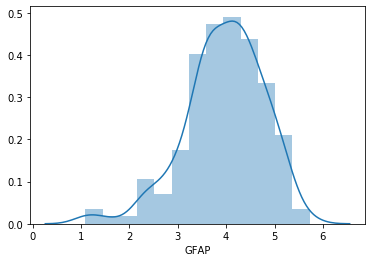

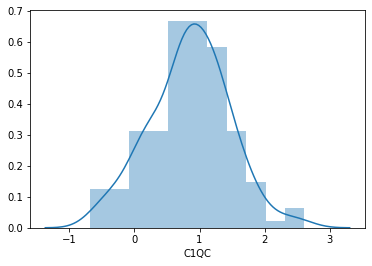

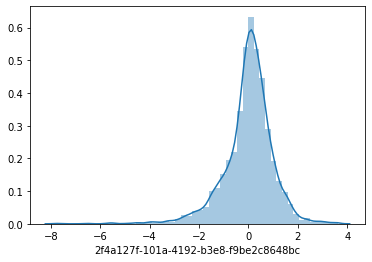

In [13]:
# plot 2 random gene distributions
sns.distplot(df_data_norm.iloc[0, :]); plt.show()
sns.distplot(df_data_norm.iloc[200, :]); plt.show()

# plot a single RNA seq profile distribution
sns.distplot(df_data_norm.iloc[:, 0]); plt.show()

Now let's visualize hierarchical clusters of up and downregulated genes with a heatmap.

/Users/nicolemoiseyev/opt/anaconda3/envs/TCGA/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


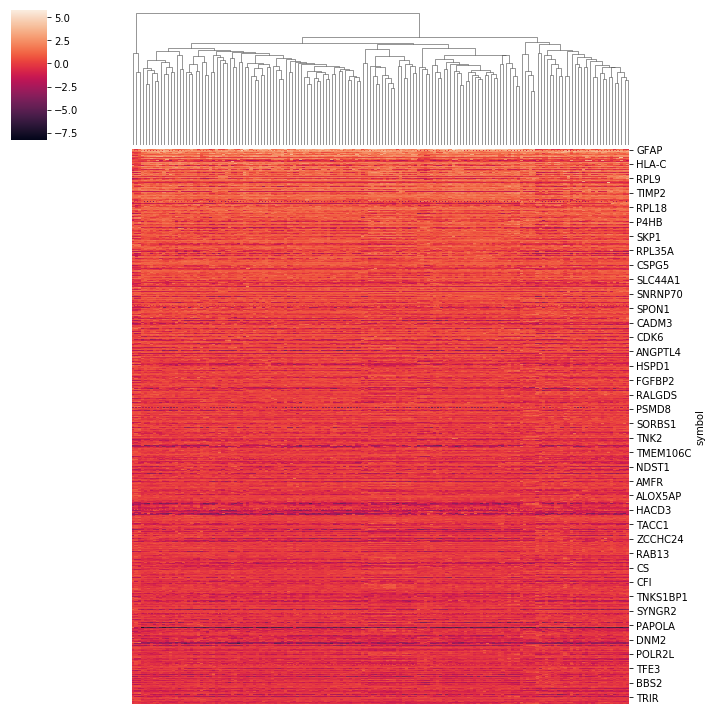

In [14]:
ax = sns.clustermap(df_data_norm,row_cluster=False,xticklabels=False)

We use PCA to initially reduce the dimensionality of the dataset before clustering while still maintaining most of the variability.

In [15]:
# PCA
data_norm_pca = PCA(
  random_state=42,
)

data_norm_pca.fit(df_data_norm.values.T)

df_data_norm_pca = pd.DataFrame(
    data_norm_pca.transform(df_data_norm.values.T),
    index=df_data_norm.T.index
)

df_data_norm_pca.columns = [
    f'PCA-{c}' # ({r:.3f})'
    for c, r in zip(df_data_norm_pca.columns, data_norm_pca.explained_variance_ratio_)
]

df_data_norm_pca.index.name = "case_id"

display(df_data_norm_pca.head())

,PCA-0,PCA-1,PCA-2,PCA-3,PCA-4,PCA-5,PCA-6,PCA-7,PCA-8,PCA-9,...,PCA-150,PCA-151,PCA-152,PCA-153,PCA-154,PCA-155,PCA-156,PCA-157,PCA-158,PCA-159
case_id,,,,,,,,,,,,,,,,,,,,,
2f4a127f-101a-4192-b3e8-f9be2c8648bc,20.174761,-5.892093,-1.269962,8.505316,-3.291006,0.651550,-6.019476,2.623959,5.679783,6.374088,...,0.085211,-0.570514,-0.733895,0.064136,-0.070288,0.161010,-0.405241,0.572157,0.048587,1.360023e-14
5252c0b7-be05-4c0c-a8ac-afe9ad459489,19.658504,-4.453976,9.079532,9.248237,-0.639329,-0.248621,5.282018,4.851089,-7.033037,-2.092201,...,-0.417445,-0.012352,-0.047466,-0.258960,-0.227008,0.484713,-0.248458,-0.263814,0.350113,1.500189e-14
15e058e8-2f33-4fb4-92af-3d9dea1fa906,-4.226670,7.822450,1.732736,3.469873,0.214101,-12.856125,-4.606029,-3.709394,4.716569,-1.252843,...,0.869803,-0.233633,0.035644,-0.358298,-0.570311,-0.431974,-0.274022,-0.124047,-0.161954,1.409983e-14
20bad0d5-3135-49a4-a119-fa7a1e56fd1b,14.476235,1.648051,5.899973,6.012139,-3.928016,-4.514060,3.634099,-0.692152,0.985341,-5.422673,...,0.342726,0.557508,-0.660888,0.299497,-0.218554,-0.100721,-0.533131,-0.625831,-0.523117,1.246225e-14
5c984433-33cf-42fc-b3ba-511efcdcab19,-8.892589,-1.563978,-2.158365,5.127898,-9.150580,-2.888256,0.403185,-4.813190,6.194639,2.297965,...,-0.157680,0.974162,-0.553104,0.154189,-0.628061,0.284686,0.351671,0.505957,0.591100,1.343370e-14


In the two plots below (PCA and UMAP projections), datapoints are color-coded by the selected feature. The size of each point represents the number of reads for that sample.

In [16]:
pca_data = merge(
        df_data_norm_pca[["PCA-0", "PCA-1"]],
        df_library_size,
        df_clinical
      )

axes = {
    "x": [min(df_data_norm_pca["PCA-0"])*1.1, max(df_data_norm_pca["PCA-0"])*1.1],
    "y": [min(df_data_norm_pca["PCA-1"])*1.1, max(df_data_norm_pca["PCA-1"])*1.1]
}
    
scatter_plot(pca_data,"PCA-0", "PCA-1",axes,features)

We further reduce the dimensionality of the dataset using the UMAP (Uniform Manifold Approximation and Projection) technique on the data projected onto the first `n_pca_components` PCA components.

In [17]:
# UMAP
data_norm_umap = UMAP(
  random_state=42,
  n_components=2,
  n_neighbors=n_neighbors,
  metric='cosine',
  min_dist=min_cluster_dist,
)

# use top n_pca_components components of PCA
n_pca_components = min(n_pca_components,df_data_norm_pca.shape[1])
data_norm_umap.fit(df_data_norm_pca.iloc[:, :n_pca_components].values)

df_data_norm_umap = pd.DataFrame(
  data_norm_umap.transform(df_data_norm_pca.iloc[:, :n_pca_components].values),
  columns=['UMAP-0', 'UMAP-1'],
  index=df_data_norm_pca.index,
)

In [18]:
# project data onto its first 2 UMAP components for visualization
umap_data = merge(
        df_data_norm_umap[["UMAP-0", "UMAP-1"]],
        df_library_size,
        df_clinical
      )

axes = {
    "x": [min(df_data_norm_umap["UMAP-0"])*1.1, max(df_data_norm_umap["UMAP-0"])*1.1],
    "y": [min(df_data_norm_umap["UMAP-1"])*1.1, max(df_data_norm_umap["UMAP-1"])*1.1]
}

scatter_plot(umap_data,"UMAP-0", "UMAP-1",axes,features)

We continue using the first 2 UMAP components.

To compute clusters, we use the Kmeans method, which requires us to define a total number of clusters. We test a range for the number of total clusters. 

For each number of clusters, we compute silhouette scores, which are a measure of how similar an entry is to its own cluster compared to other clusters. We want to maximize similarity within a cluster and differrences between clusters, so the ideal number of clusters is that which produces the highest silhouette score.

In [19]:
silhouette_scores = {}

max_clusters = 25
if (df_data_norm_umap.shape[0] < 25):
    max_clusters = df_data_norm_umap.shape[0]
    max_clusters = max(3,max_clusters)

for n in range(2, max_clusters):
    y_pred = KMeans(n_clusters=n, random_state=42).fit_predict(df_data_norm_umap.values)
    silhouette_scores[n] = silhouette_score(df_data_norm_umap.values, y_pred, metric='cosine')
silhouette_scores = pd.DataFrame([
    {'N Clusters': k, 'Silhouette Score': v}
    for k, v in silhouette_scores.items()
])
best = silhouette_scores.sort_values('Silhouette Score').iloc[-1]

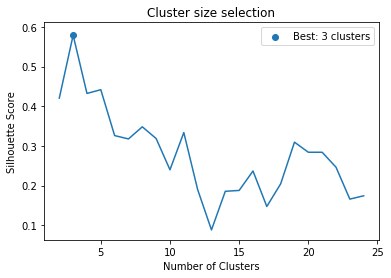

In [20]:
# plot the scores as a function of # of clusters
plt.plot(silhouette_scores['N Clusters'], silhouette_scores['Silhouette Score'])
plt.scatter([best['N Clusters']], [best['Silhouette Score']], label='Best: {} clusters'.format(int(best["N Clusters"])))
plt.legend()
plt.title('Cluster size selection')
plt.ylabel('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.show()

In [21]:
# Compute the Kmeans dataframe using the ideal number of clusters
km = KMeans(n_clusters=int(best['N Clusters']), random_state=42)
df_data_norm_km = pd.DataFrame({
'Cluster': [
    str(c)
    for c in km.fit_predict(df_data_norm_umap.values)
]}, index=df_data_norm_umap.index)

print(f'Computed {len(df_data_norm_km["Cluster"].unique())} clusters')

Computed 3 clusters


Next, we compute differential expression for each cluster. We use the <a href="http://www.maayanlab.net/CD/">Characteristic Direction method</a> for identifying differentially expressed genes among the different clusters.

In [22]:
# Get differential expression for each cluster
diff_expr = {}
for cluster, samples in df_data_norm_km.groupby('Cluster'):
    diff_expr[f"Cluster {cluster} CD"] = characteristic_direction(
        # expression outside of this cluster
        df_data_norm.loc[:, df_data_norm.columns.difference(samples.index)],
        # expression in this cluster
        df_data_norm.loc[:, samples.index],
      )['CD-coefficient']

df_diff_expr = pd.DataFrame(diff_expr)
df_diff_expr = df_diff_expr.sort_values(by='Cluster 0 CD',ascending=True)
df_diff_expr['Symbol'] = df_diff_expr.index.values

display(df_diff_expr.head())

,Cluster 0 CD,Cluster 1 CD,Cluster 2 CD,Symbol
CA3,-0.115762,0.057668,0.046354,CA3
HBA2,-0.110770,0.025531,0.077617,HBA2
C1QTNF3,-0.104254,0.043770,0.050906,C1QTNF3
CCL18,-0.097156,0.090984,-0.008867,CCL18
HBB,-0.085534,0.028012,0.050625,HBB


We fit a logistic regression on each clinical feature to see which most accurately predict the cluster each datapoint falls into. We also plot up to 5 ROC curves for features that resulted in an AUC $\gt 0.7$. 

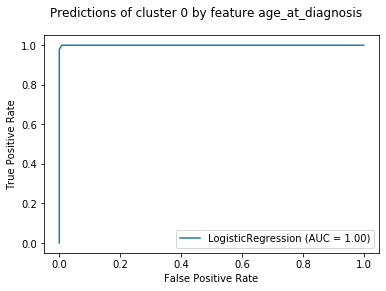

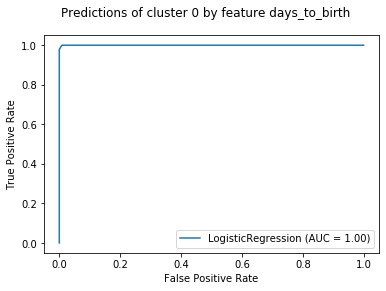

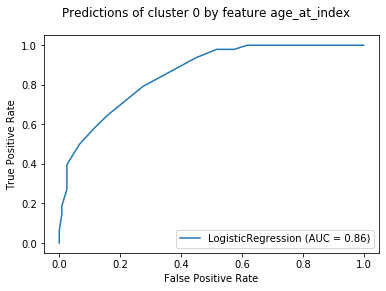

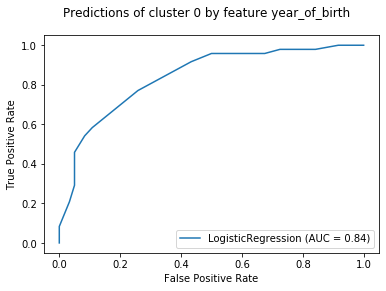

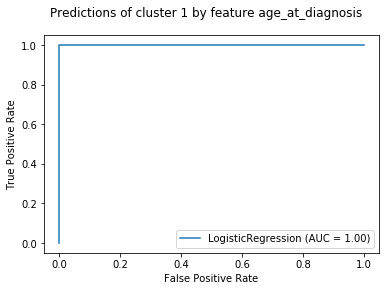

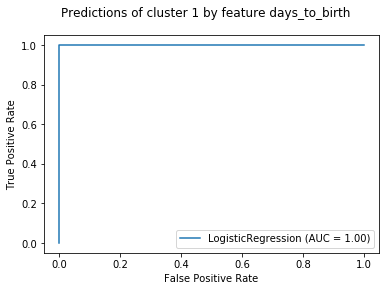

,0,1,2
Feature,,,
icd_10_code,0.500000,0.500000,0.500000
age_at_diagnosis,0.999913,1.000000,0.999904
year_of_diagnosis,0.676476,0.645996,0.698579
tissue_or_organ_of_origin,0.500000,0.500000,0.500000
days_to_birth,0.999913,1.000000,0.999904


In [23]:
# LR
aucs = {}
num_rocs_plotted = 0

for cluster, samples in df_data_norm_km.groupby('Cluster'): 
    aucs[cluster] = {}

    for feature in features:
        lr = LogisticRegression()
        X = df_clinical.copy()
        X = X[feature]
        X = pd.merge(X, df_data_norm_km, left_index = True, right_index = True)

        # drop NAs, and move on if dataset is empty
        X.replace("not reported", None)
        X = X.dropna()
        if (X.shape[0] == 0): continue

        cluster_data = X["Cluster"]
        X = X.drop(columns= ["Cluster"])

        # one-hot encode non numerical data
        if (not isinstance(X[feature][0], (int, float, complex))):
            X = pd.get_dummies(X[feature], prefix=feature)

        y_true = (cluster_data == cluster)

        if (len(set(y_true)) < 2): continue # if we only have one class in the dataset
        lr.fit(X, y_true)


        y_score = lr.predict_proba(X)[:, 1]
        auc_score = roc_auc_score(y_true, y_score)
        aucs[cluster][feature] = auc_score
        
        # plot a few good ROCs, but no more than 5
        if (auc_score > 0.7 and num_rocs_plotted < 6):
            fig = metrics.plot_roc_curve(lr, X, y_true)
            fig.figure_.suptitle(f'Predictions of cluster {cluster} by feature {feature}')
            plt.show()
            num_rocs_plotted += 1

df_cluster_aucs = pd.DataFrame(aucs)
df_cluster_aucs.index.name="Feature"
display(df_cluster_aucs.head())

# Enrichr data

We query the Enrichr API for enrichment analysis of the top most upregulated and downregulated genes for each cluster calculated above.

In [24]:
# Util functions
def enrichr_link_from_genes(genes, description='', enrichr_link='https://amp.pharm.mssm.edu/Enrichr'):
    ''' Functional access to Enrichr API
    '''
    import time, requests
    time.sleep(1)
    resp = requests.post(enrichr_link + '/addList', files={
    'list': (None, '\n'.join(genes)),
    'description': (None, description),
    })
    if resp.status_code != 200:
        raise Exception('Enrichr failed with status {}: {}'.format(
          resp.status_code,
          resp.text,
        ))
    # wait a tinybit before returning link (backoff)
    time.sleep(1)
    result = resp.json()
    return dict(result, link=enrichr_link + '/enrich?dataset=' + resp.json()['shortId'])

def enrichr_get_top_results(userListId, bg, enrichr_link='https://amp.pharm.mssm.edu/Enrichr'):
    import time, requests
    time.sleep(1)
    resp = requests.get(enrichr_link + '/enrich?userListId={}&backgroundType={}'.format(userListId, bg))
    if resp.status_code != 200:
        raise Exception('Enrichr failed with status {}: {}'.format(
          resp.status_code,
          resp.text,
        ))
    time.sleep(1)
    return pd.DataFrame(resp.json()[bg], columns=['rank', 'term', 'pvalue', 'zscore', 'combinedscore', 'overlapping_genes', 'adjusted_pvalue', '', ''])

def save_enrichr_data(cancer_type,df_diff_expr,df_clustered_umap,df_all_results,df_cluster_aucs):
    output=f"appyter_data/{cancer_type}"
    os.makedirs(output, exist_ok=True)
    df_diff_expr.to_csv(
        f'{output}/df.tsv',
        sep='\t',
        index=None
    )
    df_clustered_umap.to_csv(
        f'{output}/df_umap.tsv',
        sep='\t',
        index=None
    )
    df_all_results.to_csv(
        f'{output}/df_enrich.tsv',
        sep='\t',
        index=None
    )
    df_cluster_aucs.to_csv(
        f'{output}/cluster_aucs.csv',
        sep='\t',
        index=None
    )

In [25]:
%%appyter hide_code

'''
# Load data
base_path = f"./processed_data/{cancer}"
df = pd.read_csv(base_path + '/diffexp/graphclust/differential_expression.csv')
df_umap = pd.read_csv(base_path + '/umap/2_components/projection.csv', )
df_pca = pd.read_csv(base_path + '/pca/10_components/projection.csv')
df_clusters = pd.read_csv(base_path + '/clustering/graphclust/clusters.csv')
df_cluster_aucs = pd.read_csv(base_path + '/cluster_aucs.csv')
df_clusters['Cluster'] = df_clusters['Cluster'].astype(str)

'''

UsageError: Cell magic `%%appyter` not found.


In [26]:
# Merge data
df_clustered_umap = pd.merge(left=df_data_norm_km, left_on="case_id", right=df_data_norm_umap, right_on="case_id")
df_clustered_pca = pd.merge(left=df_data_norm_km, left_on="case_id", right=df_data_norm_pca, right_on="case_id")

In [27]:
# Get top Genes for each cluster
top_genes = {}
for cluster in df_clustered_umap['Cluster'].unique():
    fc_col = f'Cluster {cluster} Log2 fold change'
    p_col = f'Cluster {cluster} Adjusted p value'
    cd_col = f'Cluster {cluster} CD'
    if p_col in df_diff_expr.columns:
        # significant and positive fold change sorted by p value
        up_genes = df_diff_expr.loc[
          df_diff_expr[((df_diff_expr[p_col] <= 0.05) & (df_diff_expr[fc_col] > 0))][p_col].sort_values().index,
          'Symbol'
        ].iloc[:top_n_genes].dropna().values

        # significant and negative fold change sorted by p value
        dn_genes = df_diff_expr.loc[
          df_diff_expr[((df_diff_expr[p_col] <= 0.05) & (df_diff_expr[fc_col] < 0))][p_col].sort_values().index,
          'Symbol'
        ].iloc[:top_n_genes].dropna().values
    elif cd_col in df_diff_expr.columns:
        # top up genes
        up_genes = df_diff_expr.loc[df_diff_expr[cd_col].sort_values(ascending=False).iloc[:top_n_genes].index, 'Symbol'].values
        # top down genes
        dn_genes = df_diff_expr.loc[df_diff_expr[cd_col].sort_values(ascending=True).iloc[:top_n_genes].index, 'Symbol'].values
    else:
        raise Exception('Cant find col for cluster')
    # save results
    top_genes[cluster] = (up_genes, dn_genes)
    

In [28]:
# Get Enrichr links for each cluster
enrichr_links = {}

for cluster, (up_genes, dn_genes) in top_genes.items():
    up_link, dn_link = None, None
    if up_genes.size:
        up_link = enrichr_link_from_genes(up_genes, 'cluster %s up' % (cluster))
    else:
        print('cluster %s up: empty' % (cluster))
    if dn_genes.size:
        dn_link = enrichr_link_from_genes(dn_genes, 'cluster %s down' % (cluster))
    else:
        print('cluster %s down: empty' % (cluster))
    enrichr_links[cluster] = (up_link, dn_link)

# Grab top results for each cluster
all_results = []
for cluster, (up_link, dn_link) in enrichr_links.items():
    for link_type, link in [('up', up_link), ('down', dn_link)]:
        if link is None:
            continue
    for category, libraries in enrichr_libraries.items():
        for library in libraries:
            try:
                results = enrichr_get_top_results(link['userListId'], library).sort_values('pvalue').iloc[:top_n_results]
                results['link'] = link['link']
                results['library'] = library
                results['category'] = category
                results['direction'] = link_type
                results['cluster'] = cluster
                all_results.append(results)
            except:
                print('{}: {} {} {} cluster {} failed, continuing'.format(link, library, category, link_type, cluster))

df_all_results = pd.concat(all_results).reset_index()

In [29]:
# Display a dataframe with clickable enrichr links for display in the notebook

def make_clickable(link):
    return f'<a target="_blank" href="{link}">{link}</a>'

df_clickable = df_all_results.copy()

df_clickable['link'] = df_clickable["link"].apply(make_clickable)

display(HTML(df_clickable.to_html(escape=False)))

,index,rank,term,pvalue,zscore,combinedscore,overlapping_genes,adjusted_pvalue,,,link,library,category,direction,cluster
0,0,1,Hydrocephalus (HP:0000238),2.982740e-05,4.607330,48.008760,"[SOX2, COL18A1, CCND2, AKT3, ERF, HBA2, CEP41, L1CAM, TP53, FGFR3, FBN1]",5.306294e-02,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=1b2eb1f476a224bd71a880a9ee244b6d,Human_Phenotype_Ontology,Ontologies,down,0
1,1,2,Autosomal dominant inheritance (HP:0000006),3.580644e-05,2.186949,22.388632,"[CFH, PROS1, SERPINE1, HBB, CXCR4, LPL, FBLN5, MYLK, SOX2, SRPX2, KIF5A, NEFL, FLNC, CA12, ZBTB18, EDN3, PRRX1, TPM2, CAV1, TCF12, HBA2, GJB2, COL1A2, KCNQ2, ERF, SERPING1, COL6A3, TCF4, TP53, FGFR3, FBN1]",3.184983e-02,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=1b2eb1f476a224bd71a880a9ee244b6d,Human_Phenotype_Ontology,Ontologies,down,0
2,2,3,Telecanthus (HP:0000506),8.112435e-05,6.746988,63.553438,"[CCND2, EDN3, CHL1, AKT3, ERF, FGFR3, FBN1]",4.810674e-02,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=1b2eb1f476a224bd71a880a9ee244b6d,Human_Phenotype_Ontology,Ontologies,down,0
3,3,4,Abnormality of complement system (HP:0005339),9.863733e-05,16.000000,147.584973,"[CFH, C1S, C1R, CFI]",4.386895e-02,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=1b2eb1f476a224bd71a880a9ee244b6d,Human_Phenotype_Ontology,Ontologies,down,0
4,4,5,Round ear (HP:0100830),1.031692e-04,30.000000,275.374202,"[TPM2, ERF, FBN1]",3.670761e-02,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=1b2eb1f476a224bd71a880a9ee244b6d,Human_Phenotype_Ontology,Ontologies,down,0
5,0,1,BDNF signaling pathway,2.410372e-13,7.049808,204.823900,"[EGR1, TAGLN, BTG2, CDKN1A, DUSP1, IGFBP3, SERPINE1, ADM, FOS, ABLIM1, ZFP36, TFDP2, MGP, SPP1, PDE4B, FOSB, TXNIP, PLP2, FLNC, JUNB, FADS1, S100A10, FBN1]",3.639662e-10,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=1b2eb1f476a224bd71a880a9ee244b6d,BioPlanet_2019,Pathways,down,0
6,1,2,TGF-beta regulation of extracellular matrix,9.542991e-13,4.530973,125.407374,"[C1S, C1R, SERPINE1, TNFAIP2, SLC40A1, LPL, THBS2, FBLN5, LGALS3, UCHL1, SRPX2, CSRP2, EFNB3, ADAMTS1, NPTX2, JUNB, FADS1, S100A10, CA12, GSTM3, POSTN, CAV1, CKAP4, ETV5, APLN, ALDH1A3, COL1A2, TFDP2, RBP1, SCG5, CHI3L1, FBN1]",7.204958e-10,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=1b2eb1f476a224bd71a880a9ee244b6d,BioPlanet_2019,Pathways,down,0
7,2,3,Interleukin-1 regulation of extracellular matrix,3.563982e-09,8.666667,168.587356,"[CXCL8, CFH, NOS2, C1R, STMN2, TNFAIP2, FOS, ZFP36, COL1A2, FABP5, CHI3L2, SPP1, CHI3L1]",1.793871e-06,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=1b2eb1f476a224bd71a880a9ee244b6d,BioPlanet_2019,Pathways,down,0
8,3,4,Oncostatin M,1.479308e-08,4.887460,88.116533,"[ZBTB18, NMB, CDKN1A, CXCL8, C1S, NOS2, C1R, SERPINE1, LPL, PCOLCE, EGFR, COL1A2, CHL1, CHI3L2, CHI3L1, TP53, JUNB, TIMP4, TGM2]",5.584387e-06,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=1b2eb1f476a224bd71a880a9ee244b6d,BioPlanet_2019,Pathways,down,0
9,4,5,EGFR1 pathway,6.257534e-08,6.842105,113.489278,"[CDKN1A, TAGLN, DUSP1, IGFBP3, CAV1, ARHGAP1, EGFR, ZFP36L1, GJB2, UBE2N, SPP1, TXNIP, PHLDA1]",1.889775e-05,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=1b2eb1f476a224bd71a880a9ee244b6d,BioPlanet_2019,Pathways,down,0


## L1000 Data

We query the L1000FWD API to find the most similar RNA-seq signatures for each cluster based on the up and down genes.

In [46]:
# Util functions
def l100fwd_id_from_genes(up_genes, down_genes, description='', l100fwd_link='http://amp.pharm.mssm.edu/L1000FWD/'):
    ''' Functional access to L1000FWD API
    '''
    import time, requests
    time.sleep(1)
    resp = requests.post(l100fwd_link + 'sig_search', json={
    'up_genes': list(up_genes),
    'down_genes': list(down_genes),
    })
    if resp.status_code != 200:
        raise Exception('L1000FWD failed with status {}: {}'.format(
          resp.status_code,
          resp.text,
        ))
    # wait a tinybit before returning link (backoff)
    time.sleep(1)
    result = resp.json()
    return result["result_id"]

def l100fwd_get_top_results(result_id, top_n, l100fwd_link='http://amp.pharm.mssm.edu/L1000FWD/'):
    import time, requests
    time.sleep(1)
    resp = requests.get(l100fwd_link + 'result/topn/' + result_id)
    if resp.status_code != 200:
        raise Exception('L1000FWD failed with status {}: {}'.format(
          resp.status_code,
          resp.text,
        ))
    time.sleep(1)
    results = resp.json()["similar"][0:top_n]
    l1000fwd_links = [l1000fwd_sig_link(x["sig_id"]) for x in results]
    df = pd.DataFrame(results)
    df["link"] = l1000fwd_links
    
    return df
        
def l1000fwd_sig_link(sig_id):
    return 'https://amp.pharm.mssm.edu/dmoa/sig/' + sig_id

In [47]:
# Get L100FWD result ids for each cluster
l1000fwd_ids = {}

for cluster, (up_genes, dn_genes) in top_genes.items():
    l1000fwd_ids[cluster] = l100fwd_id_from_genes(up_genes, dn_genes)

# Grab top results for each cluster
all_l1000_results = []
for cluster, result_id in l1000fwd_ids.items():
    df = l100fwd_get_top_results(result_id, top_n_signatures)
    df["cluster"] = cluster
    all_l1000_results.append(df)
    
df_1000fwd = pd.concat(all_l1000_results).reset_index()

[{'qvals': 0.00108463030139864, 'combined_scores': 10.826486218043682, 'pvals': 3.13175536038305e-07, 'sig_id': 'CPC005_A549_24H:BRD-K49294207-300-01-2:10', 'scores': 0.0572792362768496, 'zscores': -1.6645346022158727}, {'qvals': 0.00913727228196373, 'combined_scores': 8.460967060796275, 'pvals': 1.32953577961908e-05, 'sig_id': 'CPC016_SKB_24H:BRD-K38477985-001-01-8:10', 'scores': 0.0548926014319809, 'zscores': -1.7351202985054945}, {'qvals': 0.00562765723554953, 'combined_scores': 9.339534023085832, 'pvals': 5.38984668311642e-06, 'sig_id': 'CPC017_ASC_24H:BRD-K11911061-003-02-8:10', 'scores': 0.0548926014319809, 'zscores': -1.7727378724289231}, {'qvals': 0.00580248645510127, 'combined_scores': 8.861811751958067, 'pvals': 6.36836686539967e-06, 'sig_id': 'CPC009_VCAP_24H:BRD-K94390040-019-01-9:10', 'scores': 0.0548926014319809, 'zscores': -1.7055157106794914}, {'qvals': 0.0019283934786256, 'combined_scores': 11.219516444534552, 'pvals': 8.08728278474515e-07, 'sig_id': 'ERG005_VCAP_6H:BR

[{'qvals': 2.51542582055705e-06, 'combined_scores': 16.972342823245963, 'pvals': 2.93796376995147e-10, 'sig_id': 'CPC019_PC3_24H:BRD-K60297835-001-01-3:10', 'scores': 0.072289156626506, 'zscores': -1.7805733849958443}, {'qvals': 2.18524675965815e-05, 'combined_scores': 13.470304937236634, 'pvals': 9.18363307004699e-09, 'sig_id': 'CPC012_NPC_24H:BRD-K69888333-001-01-7:10', 'scores': 0.0698795180722892, 'zscores': -1.6760394772677172}, {'qvals': 2.8401871068265e-05, 'combined_scores': 14.073242216801935, 'pvals': 1.39325677412125e-08, 'sig_id': 'CPC018_A375_6H:BRD-A95696820-001-01-4:10', 'scores': 0.0650602409638554, 'zscores': -1.7914075920297454}, {'qvals': 1.26190698863781e-05, 'combined_scores': 14.286523989517155, 'pvals': 2.84425162674901e-09, 'sig_id': 'CPC006_HA1E_24H:BRD-K28470988-001-01-2:10', 'scores': 0.0650602409638554, 'zscores': -1.6717143131272723}, {'qvals': 6.28611902152077e-05, 'combined_scores': 12.503582310168856, 'pvals': 5.8736424784702e-08, 'sig_id': 'CPC015_A549_

[{'qvals': 1.41252198818132e-05, 'combined_scores': 15.117217064596, 'pvals': 6.5991823596969e-10, 'sig_id': 'CPC006_PC3_24H:BRD-K01121114-001-01-9:10', 'scores': 0.0726392251815981, 'zscores': -1.646664213441322}, {'qvals': 0.000140686352414146, 'combined_scores': 13.00229932036961, 'pvals': 1.6431866244732e-08, 'sig_id': 'CPC007_A375_6H:BRD-K84855052-001-04-0:10', 'scores': 0.0653753026634383, 'zscores': -1.670320699912077}, {'qvals': 0.00118057055495027, 'combined_scores': 9.93125294752035, 'pvals': 5.72540311012411e-07, 'sig_id': 'CPC005_A375_24H:BRD-A08003242-001-02-7:10', 'scores': 0.062953995157385, 'zscores': -1.5909875691514186}, {'qvals': 0.000994393102523572, 'combined_scores': 11.457036707262638, 'pvals': 3.71657586964824e-07, 'sig_id': 'CPC019_MCF7_6H:BRD-K77480336-001-02-8:10', 'scores': 0.0605326876513317, 'zscores': -1.7818493805304905}, {'qvals': 0.00124938947153399, 'combined_scores': 10.609397992739137, 'pvals': 6.73591147395296e-07, 'sig_id': 'CPC014_A549_24H:BRD-U2

In [ ]:
display(df_all_results)

In [48]:
# Display a dataframe with clickable enrichr links for display in the notebook

def make_clickable(link):
    return f'<a target="_blank" href="{link}">{link}</a>'

df_clickable = df_1000fwd.copy()

df_clickable['link'] = df_clickable["link"].apply(make_clickable)

display(HTML(df_clickable.to_html(escape=False)))

,index,qvals,combined_scores,pvals,sig_id,scores,zscores,link,cluster
0,0,0.001085,10.826486,3.131755e-07,CPC005_A549_24H:BRD-K49294207-300-01-2:10,0.057279,-1.664535,https://amp.pharm.mssm.edu/dmoa/sig/CPC005_A549_24H:BRD-K49294207-300-01-2:10,0
1,1,0.009137,8.460967,1.329536e-05,CPC016_SKB_24H:BRD-K38477985-001-01-8:10,0.054893,-1.735120,https://amp.pharm.mssm.edu/dmoa/sig/CPC016_SKB_24H:BRD-K38477985-001-01-8:10,0
2,2,0.005628,9.339534,5.389847e-06,CPC017_ASC_24H:BRD-K11911061-003-02-8:10,0.054893,-1.772738,https://amp.pharm.mssm.edu/dmoa/sig/CPC017_ASC_24H:BRD-K11911061-003-02-8:10,0
3,3,0.005802,8.861812,6.368367e-06,CPC009_VCAP_24H:BRD-K94390040-019-01-9:10,0.054893,-1.705516,https://amp.pharm.mssm.edu/dmoa/sig/CPC009_VCAP_24H:BRD-K94390040-019-01-9:10,0
4,4,0.001928,11.219516,8.087283e-07,ERG005_VCAP_6H:BRD-A39996500-001-01-4:5,0.054893,-1.841621,https://amp.pharm.mssm.edu/dmoa/sig/ERG005_VCAP_6H:BRD-A39996500-001-01-4:5,0
5,5,0.009137,8.423862,1.286391e-05,CPC014_MCF7_6H:BRD-K84937637-001-03-2:10,0.052506,-1.722450,https://amp.pharm.mssm.edu/dmoa/sig/CPC014_MCF7_6H:BRD-K84937637-001-03-2:10,0
6,6,0.011144,7.832511,2.004400e-05,CPC006_PC3_24H:BRD-A69951442-001-01-3:10,0.052506,-1.667196,https://amp.pharm.mssm.edu/dmoa/sig/CPC006_PC3_24H:BRD-A69951442-001-01-3:10,0
7,7,0.007772,8.281892,9.258986e-06,CPC003_HCC515_6H:BRD-A34205397-001-03-7:10,0.052506,-1.645375,https://amp.pharm.mssm.edu/dmoa/sig/CPC003_HCC515_6H:BRD-A34205397-001-03-7:10,0
8,8,0.005802,8.684264,6.370550e-06,CPC006_VCAP_6H:BRD-A79768653-001-02-1:10,0.052506,-1.671393,https://amp.pharm.mssm.edu/dmoa/sig/CPC006_VCAP_6H:BRD-A79768653-001-02-1:10,0
9,9,0.009191,8.210871,1.416944e-05,CPC010_MCF7_24H:BRD-A54632525-001-03-2:10,0.052506,-1.693435,https://amp.pharm.mssm.edu/dmoa/sig/CPC010_MCF7_24H:BRD-A54632525-001-03-2:10,0
